# Composite Bloq Manipulation
[`CompositeBloq`](/reference/qualtran/CompositeBloq.md) is our primary container class for writing quantum programs. 

The [`Bloq`](/reference/qualtran/Bloq.md) interface describes a black-box quantum operation that guarantees certain input and output registers (i.e. a signature) and can be annotated with known quantities (like resource counts). A special type of [`Bloq`](/reference/qualtran/Bloq.md) is [`CompositeBloq`](/reference/qualtran/CompositeBloq.md). Instead of having its own name, attributes, resource counts, and others, it is a container class that is simply a collection of sub-bloqs. Specifically, it encodes a graph where we not only include the sub-bloqs but which outputs are connected to which inputs. 

In [1]:
from typing import *
import numpy as np

## Bloq Builder
Let's see how we can take an example [`Bloq`](/reference/qualtran/Bloq.md), create two instances of them, and wire them up in two different ways.

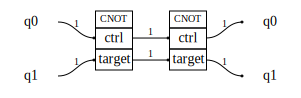

In [2]:
from qualtran import Bloq, BloqBuilder, Signature, Soquet
from qualtran.drawing import show_bloq

# An example Bloq:
from qualtran.bloqs.basic_gates import CNOT
bloq = CNOT()

# Wire up (way 1)
bb = BloqBuilder()
q0 = bb.add_register('q0', 1)
q1 = bb.add_register('q1', 1)
q0, q1 = bb.add(bloq, ctrl=q0, target=q1)
q0, q1 = bb.add(bloq, ctrl=q0, target=q1)
cbloq = bb.finalize(q0=q0, q1=q1)
show_bloq(cbloq)

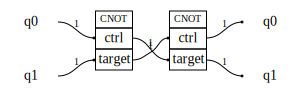

In [3]:
# Wire up (way 2)
bb = BloqBuilder()
q0 = bb.add_register('q0', 1)
q1 = bb.add_register('q1', 1)
q0, q1 = bb.add(bloq, ctrl=q0, target=q1)
q0, q1 = bb.add(bloq, ctrl=q1, target=q0) ## !!
cbloq = bb.finalize(q0=q0, q1=q1)
show_bloq(cbloq)

We declare our external-facing registers to be named `q0` and `q1`. By choice, we likewise name our quantum variables `q0` and `q1` throughout, pass them as keyword arguments to `add`, and receive *new* quantum variables to which we re-assign the names `q0` and `q1`.

In the highlighted line in "way 2", we use the control output from the first bloq instance as the `target` input to the second bloq instance (causing the crossing of lines in the diagram). We still bind the output of the second `control` register to the composite bloq's `q0` register.

## Decompose Bloq

You can direcly contruct composite bloqs using [`BloqBuilder`](/reference/qualtran/BloqBuilder.md) per above. The other main use of composite bloqs is the return type of `Bloq.decompose_bloq()`. When defining a bloq, you can provide its decomposition by overriding the `build_composite_bloq` method. In this case, the bloq builder and registers are set up for you and you just need to add the operations.

In [4]:
class TestTwoCNOT(Bloq):
    @property
    def signature(self) -> Signature:
        return Signature.build(q1=1, q2=1)

    def build_composite_bloq(
        self, bb: 'BloqBuilder', q1: 'Soquet', q2: 'Soquet'
    ) -> Dict[str, 'Soquet']:
        q1, q2 = bb.add(CNOT(), ctrl=q1, target=q2)
        q1, q2 = bb.add(CNOT(), ctrl=q2, target=q1)
        return {'q1': q1, 'q2': q2}

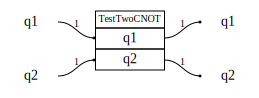

In [5]:
show_bloq(TestTwoCNOT())

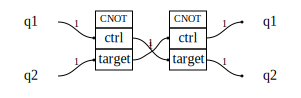

In [6]:
show_bloq(TestTwoCNOT().decompose_bloq())

## Debug Text

The graph structure is most easily viewed as a diagram, but composite bloqs also expose a textual description where each sub-bloq instance is printed in topologically-sorted order. Below each subbloq, the incoming (left) and outgoing (right) connections are printed.

In [7]:
print(cbloq.debug_text())

CNOT<0>
  LeftDangle.q0 -> ctrl
  LeftDangle.q1 -> target
  target -> CNOT<1>.ctrl
  ctrl -> CNOT<1>.target
--------------------
CNOT<1>
  CNOT<0>.target -> ctrl
  CNOT<0>.ctrl -> target
  ctrl -> RightDangle.q0
  target -> RightDangle.q1


## Valid Decomposition

We can use various assertion helpers to check that a given composite bloq is valid, i.e. that it follows the invariants of the data structure. 

In [8]:
from qualtran.testing import (
    assert_registers_match_parent,
    assert_registers_match_dangling,
    assert_soquets_belong_to_registers,
    assert_soquets_used_exactly_once,
    assert_connections_compatible
)

bloq = TestTwoCNOT()
assert_registers_match_parent(bloq)

cbloq = bloq.decompose_bloq()
assert_registers_match_dangling(cbloq)
assert_soquets_belong_to_registers(cbloq)
assert_soquets_used_exactly_once(cbloq)
assert_connections_compatible(cbloq)

Of course, we provide a helper function that does all of the checks in one call:

In [9]:
from qualtran.testing import assert_valid_bloq_decomposition

assert_valid_bloq_decomposition(bloq)
print("Checks out!")

Checks out!


## Iter Bloqnections

It can be useful to iterate over the graph in this form: namely bloq instances along with their predecessor and successor connections. Using `composite_bloq.iter_bloqnections()` we can quickly sketch a simple implementation of `debug_text()`. 

In [10]:
for binst, pred_cxns, succ_cxns in cbloq.iter_bloqnections():
    print(binst)
    for pred in pred_cxns:
        print('  ', pred.left, '->', pred.right)
    for succ in succ_cxns:
        print('  ', succ.left, '->', succ.right)

CNOT<0>
   LeftDangle.q1 -> CNOT<0>.ctrl
   LeftDangle.q2 -> CNOT<0>.target
   CNOT<0>.target -> CNOT<1>.ctrl
   CNOT<0>.ctrl -> CNOT<1>.target
CNOT<1>
   CNOT<0>.target -> CNOT<1>.ctrl
   CNOT<0>.ctrl -> CNOT<1>.target
   CNOT<1>.ctrl -> RightDangle.q1
   CNOT<1>.target -> RightDangle.q2


## Copy

We can perform a copy of a composite bloq, which will produce a new composite bloq whose bloq instances are different. This is an incredibly uninteresting operation in the abstract because CompositeBloqs are immutable. However, you can inspect the `copy` code to see how it forms the basis for more interesting copy-with-modification methods discussed later.

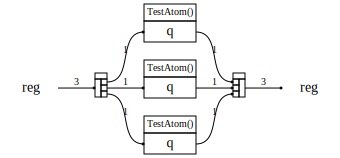

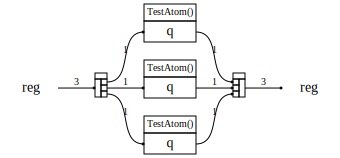

In [11]:
from qualtran.bloqs.for_testing import TestAtom, TestSerialCombo, TestParallelCombo

cbloq = TestParallelCombo().decompose_bloq()
cbloq2 = cbloq.copy()

# They're the same!
show_bloq(cbloq)
show_bloq(cbloq2)

To try to show that something is actually happening, we use the following monkey-patching code to override [`BloqBuilder`](/reference/qualtran/BloqBuilder.md)'s internal counter for numbering bloq instances so the copied version has different indices.

In [12]:
from contextlib import contextmanager

@contextmanager
def hacked_bb_init():
    # monkey-patch BloqBuilder to offset the bloq instance counter.
    
    old_bb_init_method = BloqBuilder.__init__
    
    def _new_init(self, *args, **kwargs):
        old_bb_init_method(self, *args, **kwargs)
        self._i = 100

    try:
        BloqBuilder.__init__ = _new_init
        yield
    finally:
        BloqBuilder.__init__ = old_bb_init_method

Now when we iterate through the original cbloq's connections and the copy's, we see that the connectivity is the same but the bloq instance indices are different.

In [13]:
cbloq = TestParallelCombo().decompose_bloq()

with hacked_bb_init():
    cbloq2 = cbloq.copy()

for cxn1, cxn2 in zip(cbloq.connections, cbloq2.connections):
    print(cxn1)
    print(cxn2)
    print()

LeftDangle.reg -> Split<0>.reg
LeftDangle.reg -> Split<100>.reg

Split<0>.reg[0] -> TestAtom()<1>.q
Split<100>.reg[0] -> TestAtom()<101>.q

Split<0>.reg[1] -> TestAtom()<2>.q
Split<100>.reg[1] -> TestAtom()<102>.q

Split<0>.reg[2] -> TestAtom()<3>.q
Split<100>.reg[2] -> TestAtom()<103>.q

TestAtom()<1>.q -> Join<4>.reg[0]
TestAtom()<101>.q -> Join<104>.reg[0]

TestAtom()<2>.q -> Join<4>.reg[1]
TestAtom()<102>.q -> Join<104>.reg[1]

TestAtom()<3>.q -> Join<4>.reg[2]
TestAtom()<103>.q -> Join<104>.reg[2]

Join<4>.reg -> RightDangle.reg
Join<104>.reg -> RightDangle.reg



## Iter Bloqsoqs

Under the hood of `CompositeBloq.copy()` and many of the methods that follow use `CompositeBloq.iter_bloqsoqs()` in coordination with `map_soqs` to iterate over the contents of a composite bloq in a form suitable for making a copy (optionally with modification). We reproduce the code used to implement `copy`.

In [14]:
from qualtran import SoquetT

# Start a new BloqBuilder to build up our copy
bb, _ = BloqBuilder.from_signature(cbloq.signature)

# We'll have to "map" the soquets from our template cbloq to our new one
soq_map: List[Tuple[SoquetT, SoquetT]] = []
    
# Iteration yields each bloq instance as well as its input and output soquets.
for binst, in_soqs, old_out_soqs in cbloq.iter_bloqsoqs():
    # We perform the mapping
    in_soqs = bb.map_soqs(in_soqs, soq_map)
    
    # Optional modification can go here!
    # We add a new bloq instance based on the template cbloq.
    # We use `bb.add_t` so the return value is always a tuple, even
    # if there's only one value returned.
    new_out_soqs = bb.add_t(binst.bloq, **in_soqs)
    
    # We are responsible for updating the mapping from old soquets (provided
    # to us) with our new soquets obtained from the bloq builder.
    soq_map.extend(zip(old_out_soqs, new_out_soqs))

# We finalize the new builder with a mapped version of the final,
# right-dangling soquets.
fsoqs = bb.map_soqs(cbloq.final_soqs(), soq_map)
copy = bb.finalize(**fsoqs)
print(copy)

CompositeBloq([5 subbloqs...])


## Add from

We can use `bb.add_from` to add all the contents of a composite bloq to the current bloq-under-construction. This has the effect of flattening one level of structure during bloq construction. In the following cells, we connect `TestParallelBloq`s serially but vary when we call `bb.add` vs `bb.add_from`.

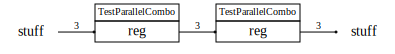

In [15]:
# Just call add
bb = BloqBuilder()
stuff = bb.add_register('stuff', 3)
stuff = bb.add(TestParallelCombo(), reg=stuff)
stuff = bb.add(TestParallelCombo(), reg=stuff)
bloq = bb.finalize(stuff=stuff)
show_bloq(bloq)

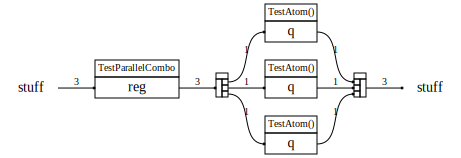

In [16]:
# `add_from` on second one
bb = BloqBuilder()
stuff = bb.add_register('stuff', 3)
stuff, = bb.add_t(TestParallelCombo(), reg=stuff)
stuff, = bb.add_from(TestParallelCombo(), reg=stuff)
bloq = bb.finalize(stuff=stuff)

show_bloq(bloq)

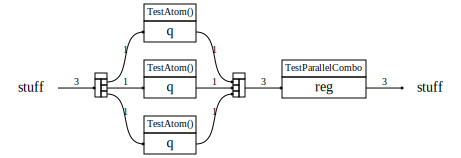

In [17]:
# `add_from` on first one
bb = BloqBuilder()
stuff = bb.add_register('stuff', 3)
stuff, = bb.add_from(TestParallelCombo(), reg=stuff)
stuff, = bb.add_t(TestParallelCombo(), reg=stuff)
bloq = bb.finalize(stuff=stuff)

show_bloq(bloq)

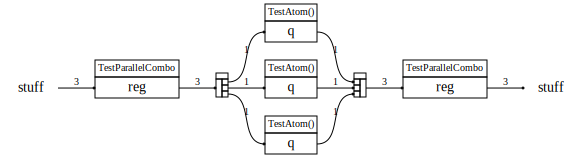

In [18]:
# `add_from` on middle one
bb = BloqBuilder()
stuff = bb.add_register('stuff', 3)
stuff, = bb.add_t(TestParallelCombo(), reg=stuff)
stuff, = bb.add_from(TestParallelCombo().decompose_bloq(), reg=stuff)
stuff, = bb.add_t(TestParallelCombo(), reg=stuff)

bloq = bb.finalize(stuff=stuff)
show_bloq(bloq)

## Flatten

If we already have a composite bloq, we can "flatten" its subbloqs. The `flatten` and `flatten_once` methods take a predicate which can choose whether to flatten a bloq instance or keep it as-is.

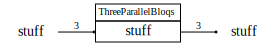

In [19]:
class ThreeParallelBloqs(Bloq):
    @property
    def signature(self) -> Signature:
        return Signature.build(stuff=3)

    def build_composite_bloq(
            self, bb: 'BloqBuilder', stuff: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        stuff = bb.add(TestParallelCombo(), reg=stuff)
        stuff = bb.add(TestParallelCombo(), reg=stuff)
        stuff = bb.add(TestParallelCombo(), reg=stuff)
        return {'stuff': stuff}

# Note! We're using `.as_composite_bloq()` to wrap the Bloq
# into a compute graph with one node.
three_p = ThreeParallelBloqs().as_composite_bloq()
show_bloq(three_p)

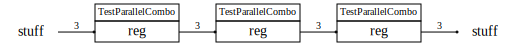

In [20]:
# Do one flattening operation; here equivalent to `.decompose_bloq()`
# on the original bloq.
flat_three_p = three_p.flatten_once()
show_bloq(flat_three_p)

Now we have a [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) with three subbloqs. What if we wanted to continue decomposing? A naive approach would be to simply call `.decompose_bloq()` on each subbloqs. We'll do this in the next cell and see what happens.

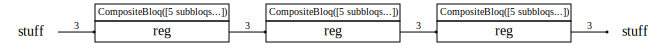

In [21]:
# Go through and decompose each subbloq
# We'll manually code this up in this notebook since this isn't a useful operation.
bb, _ = BloqBuilder.from_signature(flat_three_p.signature)
soq_map: List[Tuple[SoquetT, SoquetT]] = []
    
for binst, in_soqs, old_out_soqs in flat_three_p.iter_bloqsoqs():
    in_soqs = bb.map_soqs(in_soqs, soq_map)
    
    # Here, we call `decompose_bloq()` before adding in the subbloq
    new_out_soqs = bb.add_t(binst.bloq.decompose_bloq(), **in_soqs)
    soq_map.extend(zip(old_out_soqs, new_out_soqs))

fsoqs = bb.map_soqs(flat_three_p.final_soqs(), soq_map)
decompose_children = bb.finalize(**fsoqs)
show_bloq(decompose_children)

This is still a [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) with three subbloqs. The only difference is now the subbloqs are each compute graphs of their own. This likely isn't what we want. Instead, we want to do the equivalent of `flatMap` with the decompose operation: namely, decompose the subbloqs and remove a layer of nesting. This is what the `flatten_once` method achieves.

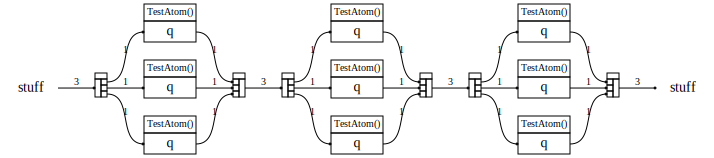

In [22]:
# Actually do a flattening operation on all the subbloqs
show_bloq(
    flat_three_p.flatten_once()
)

You can use the optional predicate to control which subbloqs get decomposed and flattened.

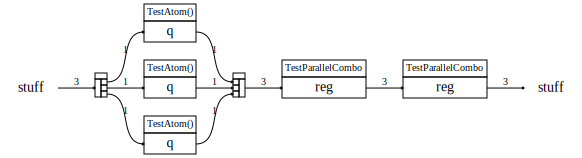

In [23]:
# Flatten by binst properties
show_bloq(
    flat_three_p.flatten_once(lambda binst: binst.i == 1)
)

The `.flatten` method will repeatedly call `flatten_once` until you can't flatten any more.

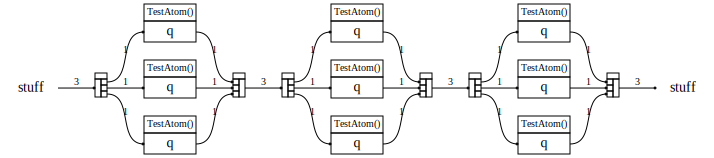

In [24]:
# Note that in this example, we have gone back to the original `three_p` starting composite bloq.
# This will perform two flattening operations.
show_bloq(
    three_p.flatten()
)